In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#Get rid of SettingWithCopyWarnings
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  
import scipy.stats as stats

In [10]:
#We drop the unnecessary columns
roses = pd.read_csv('../../Data/processedData/Roses/labeledBigRose.csv', sep='\t')
roses = roses.drop(['observer_id', 'login', 'name', 'photo_page_url', 'photo_url_square', 'photo_uuid', 'license', 'quality_grade', 'taxon_id', 'rank', 'rank_level', 'active', 'ancestry', 'photo_id', 'extension', 'width', 'height', 'observation_uuid', 'position', 'Unnamed: 0', 'positional_accuracy'], axis=1)
roses = roses.dropna()

In [11]:
#We add two new columns onto roses that give the year of the observation and the number of days since the beginning of the year for that observation.
def get_year(date):
    try:
        return int(date[:4])
    except:
        return None

def days_since_start_of_year(month, day):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = sum(days_in_month[:month - 1]) + day
    return days

def days_to_date(days):
    # Find the month and day corresponding to the average number of days
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for i, days_this_month in enumerate(days_in_month):
        if days <= days_this_month:
            return i + 1, int(days)
        days -= days_this_month
    return 12, int(days)

def get_day(date):
    return days_since_start_of_year(int(date[5:7]), int(date[8:]))


roses["year"] = roses['observed_on'].apply(get_year)
roses["day"] = roses['observed_on'].apply(get_day)
roses.head()

,latitude,longitude,observed_on,taxon_name,fileName,inBloom,year,day
0,41.414216,-72.581309,2011-06-10,Rosa multiflora,D:\Roses\36944.jpg,True,2011,161
1,44.005329,-73.148262,2011-08-03,Rosa multiflora,D:\Roses\48170.jpg,False,2011,215
2,40.591600,-74.228482,2006-05-25,Rosa multiflora,D:\Roses\94456.jpg,True,2006,145
3,44.167488,-73.136091,2012-03-18,Rosa multiflora,D:\Roses\91270.jpg,False,2012,77
4,40.992833,-81.680167,2012-04-25,Rosa multiflora,D:\Roses\106185.jpg,False,2012,115


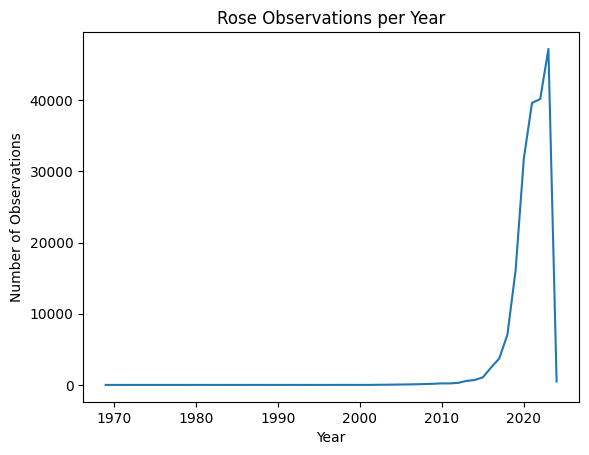

In [12]:
#First let's look at how our data is distributed over the years. We plot the total number of observations as a function of year. 
yearList = roses['year'].unique()
yearList.sort()
counts = []
for year in yearList:
    counts.append(roses[roses['year'] == year].shape[0])

plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.title("Rose Observations per Year")
plt.plot(yearList, counts)


We can see that observations before about 2015 are pretty few and far between. We also see that there are only a few observations in 2024. We limit our data to only those observations between 2015 and 2023. This will help eliminate outliers in the data set. This got rid of around 3000 total observations ~1.5% of the data. This will ensure that each year has at least 1000 observations.

In [13]:
roses = roses[roses['year'] >= 2015]
roses = roses[roses['year'] < 2024]
roses

,latitude,longitude,observed_on,taxon_name,fileName,inBloom,year,day
324,40.664836,-74.595677,2015-01-11,Rosa multiflora,D:\Roses\1481814.JPG,False,2015,11
325,40.640327,-74.448477,2015-01-07,Rosa multiflora,D:\Roses\1481860.JPG,False,2015,7
326,40.634164,-74.490802,2015-01-05,Rosa multiflora,D:\Roses\1481904.JPG,False,2015,5
327,40.632747,-74.461598,2015-01-06,Rosa multiflora,D:\Roses\1481928.JPG,False,2015,6
328,40.602435,-74.532516,2015-01-02,Rosa multiflora,D:\Roses\1481961.JPG,False,2015,2
...,...,...,...,...,...,...,...,...
193743,48.156175,-122.675383,2022-09-17,Rosa nutkana,D:\Roses\346582480.jpg,False,2022,260
193744,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792124.jpeg,False,2015,161
193745,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792131.jpeg,True,2015,161
193746,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792145.jpeg,False,2015,161


Now let's see how the average flowering day is trending and how it compares to the average observation day. To do this we'll make a new dataframe with rows indexed by years. 

In [71]:

observations = pd.DataFrame()
observations["year"] = roses['year'].unique()

def get_count(year):
    return roses[roses['year'] == year].shape[0]
    
observations['count'] = observations['year'].apply(get_count)

def get_flowering_count(year):
    observationsFromYear = roses[roses['year'] == year]
    observationsFromYearInBloom = observationsFromYear[observationsFromYear['inBloom'] == True]
    floweringCount = observationsFromYearInBloom.shape[0]
    return floweringCount

observations['floweringCount'] = observations['year'].apply(get_flowering_count)

def get_flowering_proportion(year):
    obCount = observations[observations['year'] == year]['count'].iloc[0]
    floweringCount = observations[observations['year'] == year]['floweringCount'].iloc[0]
    return floweringCount/obCount

observations['floweringProportion'] = observations['year'].apply(get_flowering_proportion)

def get_average_flowering_day(year):
    observationsFromYear = roses[roses["year"] == year]
    observationsFromYearInBloom = observationsFromYear[observationsFromYear['inBloom'] == True]
    return int(observationsFromYearInBloom['day'].mean())

def get_average_observation_day(year):
    return int(roses[roses["year"] == year]['day'].mean())

observations['averageFloweringDay'] = observations['year'].apply(get_average_flowering_day)
observations['averageObservationDay'] = observations['year'].apply(get_average_observation_day)


We plot the average flowering day vs the average observation day along with lines of best fit for each. 

In [74]:
modelFlower = LinearRegression()
modelFlower.fit(np.array(observations['year']).reshape(-1,1), np.array(observations['averageFloweringDay']).reshape(-1,1))

modelAll = LinearRegression()
modelAll.fit(np.array(observations['year']).reshape(-1,1), np.array(observations['averageObservationDay']).reshape(-1,1))

LinearRegression()

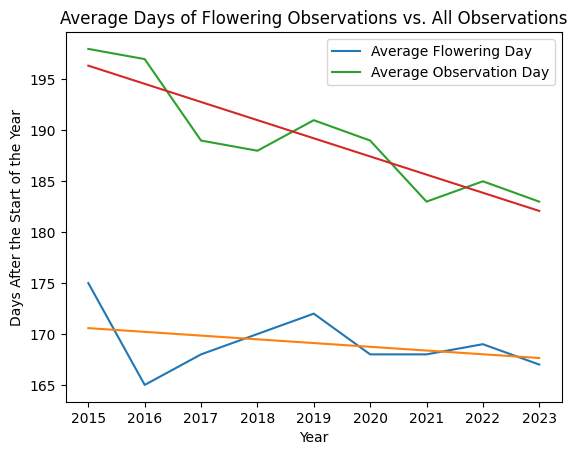

In [76]:

plt.xlabel("Year")
plt.ylabel("Days After the Start of the Year")
plt.title("Average Days of Flowering Observations vs. All Observations")

plt.plot(observations['year'], observations['averageFloweringDay'], label = 'Average Flowering Day')
plt.plot(observations['year'], modelFlower.predict(np.array(observations['year']).reshape(-1,1)))
plt.plot(observations['year'], observations['averageObservationDay'], label = 'Average Observation Day')
plt.plot(observations['year'], modelAll.predict(np.array(observations['year']).reshape(-1,1)))

plt.legend()


We can see that the trend is earlier and earlier in the year. We perform a two-sample t-test to determine whether the mean flowering day before 2020 is ealier than 2020 or later. This date was chosen in order to have a large number of data points both before and after it. 

In [113]:
beforeData = np.array(list(floweringDates[floweringDates["Year"] < 2020]['Days']))
afterData = np.array(list(floweringDates[floweringDates["Year"] >= 2020]['Days']))

# Print the variance of both data groups
print("Variances: ")
print(np.var(beforeData), np.var(afterData))
print("Means: ")
print(np.mean(beforeData), np.mean(afterData))

Variances: 
1824.5224733759042 1601.0642389124605
Means: 
171.505499276411 168.32639624640532


In [112]:
#We see the ratio < 4 so we can use a 2 sample t-test with equal variances. 
stats.ttest_ind(beforeData, afterData, equal_var=True)

TtestResult(statistic=8.39313697116405, pvalue=4.8095385208513527e-17, df=79888.0)

This is the two-sided p-value. Since the after mean is smaller then the one sided p-value would be 1/2 of this. We see that we can be relatively certain that the observed flowering date has gotten earlier in the year when we compare years before 2020 and those after 2019. Next I want to look at the probability of a rose flowering, given that it was observed for each week of the year. This will help us mitigate the impact of the general trend of earlier and earlier observations.For each year we look at how the distribution of of observed flowering plants changes.

In [14]:
def get_week(day):
    return day//7

roses["week"] = roses["day"].apply(get_week)

In [15]:
roses

,latitude,longitude,observed_on,taxon_name,fileName,inBloom,year,day,week
324,40.664836,-74.595677,2015-01-11,Rosa multiflora,D:\Roses\1481814.JPG,False,2015,11,1
325,40.640327,-74.448477,2015-01-07,Rosa multiflora,D:\Roses\1481860.JPG,False,2015,7,1
326,40.634164,-74.490802,2015-01-05,Rosa multiflora,D:\Roses\1481904.JPG,False,2015,5,0
327,40.632747,-74.461598,2015-01-06,Rosa multiflora,D:\Roses\1481928.JPG,False,2015,6,0
328,40.602435,-74.532516,2015-01-02,Rosa multiflora,D:\Roses\1481961.JPG,False,2015,2,0
...,...,...,...,...,...,...,...,...,...
193743,48.156175,-122.675383,2022-09-17,Rosa nutkana,D:\Roses\346582480.jpg,False,2022,260,37
193744,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792124.jpeg,False,2015,161,23
193745,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792131.jpeg,True,2015,161,23
193746,49.194722,-123.003199,2015-06-10,Rosa nutkana,D:\Roses\346792145.jpeg,False,2015,161,23


In [18]:
#For each year I want to compute the proportion of observations flowering for each week in that year. Each year needs a list of 52 numbers. 

proportions = pd.DataFrame(columns=list(roses["year"].unique()))


In [21]:
for year in proportions.columns:
    curr_obs = roses[roses["year"] == year]
    prop_list = []
    for week in range(52):
        obs_this_week = curr_obs[curr_obs["week"] == week]
        num_obs = obs_this_week.shape[0]
        flowering_obs_this_week = obs_this_week[obs_this_week["inBloom"] == True]
        num_flowering_obs = flowering_obs_this_week.shape[0]
        if num_obs == 0:
            num_obs = 1
        prop_list.append(num_flowering_obs/num_obs)
    proportions[year] = prop_list

In [22]:
proportions

,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,0.000000,0.000000,0.166667,0.000000,0.043478,0.016000,0.000000,0.053333,0.014286
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.032609,0.042763,0.058065,0.006494
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005435,0.044335,0.053398
3,0.000000,0.000000,0.000000,0.000000,0.042553,0.014286,0.005952,0.126984,0.034965
4,0.000000,0.000000,0.000000,0.033333,0.000000,0.018018,0.015038,0.039683,0.015038
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.019417,0.022727,0.112903,0.011111
6,0.000000,0.000000,0.000000,0.000000,0.066667,0.046358,0.048077,0.051282,0.000000
7,0.000000,0.000000,0.259259,0.076923,0.043478,0.027972,0.012739,0.100000,0.039648
8,0.222222,0.000000,0.000000,0.058824,0.016949,0.018634,0.024242,0.030568,0.020576
9,0.000000,0.000000,0.000000,0.052632,0.111111,0.043165,0.028902,0.048077,0.066148


This data tells me, if I see a rose plant in a given week of a given year, how likely is it to be flowering. If flowering times are shifting earlier in the season, we should expect the histogram of observed flowering proportions to shift earlier in that direction as time moves on. 

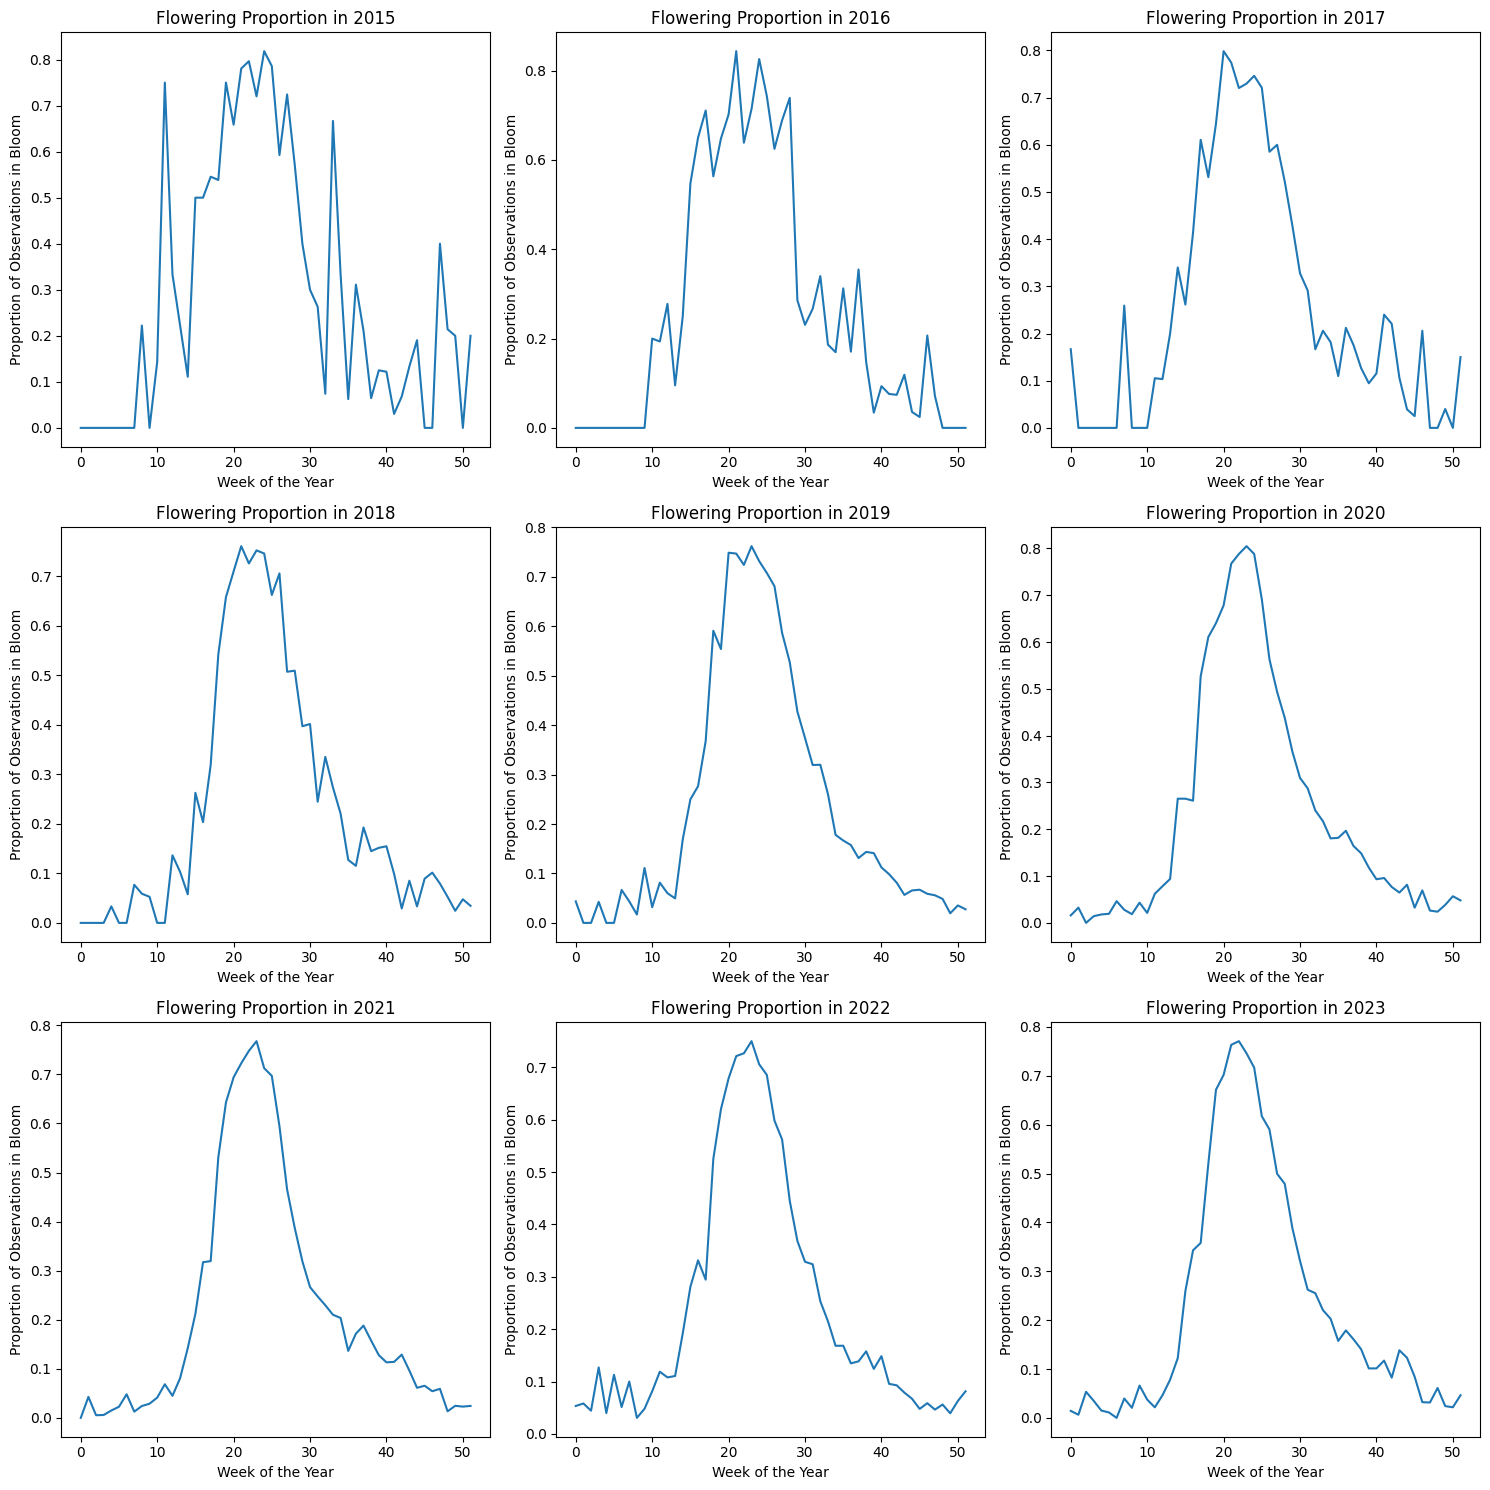

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Loop through each year and create a plot in the corresponding subplot
for i, year in enumerate(proportions.columns):
    axs[i].plot(list(range(52)), list(proportions[year]))
    axs[i].set_xlabel("Week of the Year")
    axs[i].set_ylabel("Proportion of Observations in Bloom")
    axs[i].set_title("Flowering Proportion in " + str(year))

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

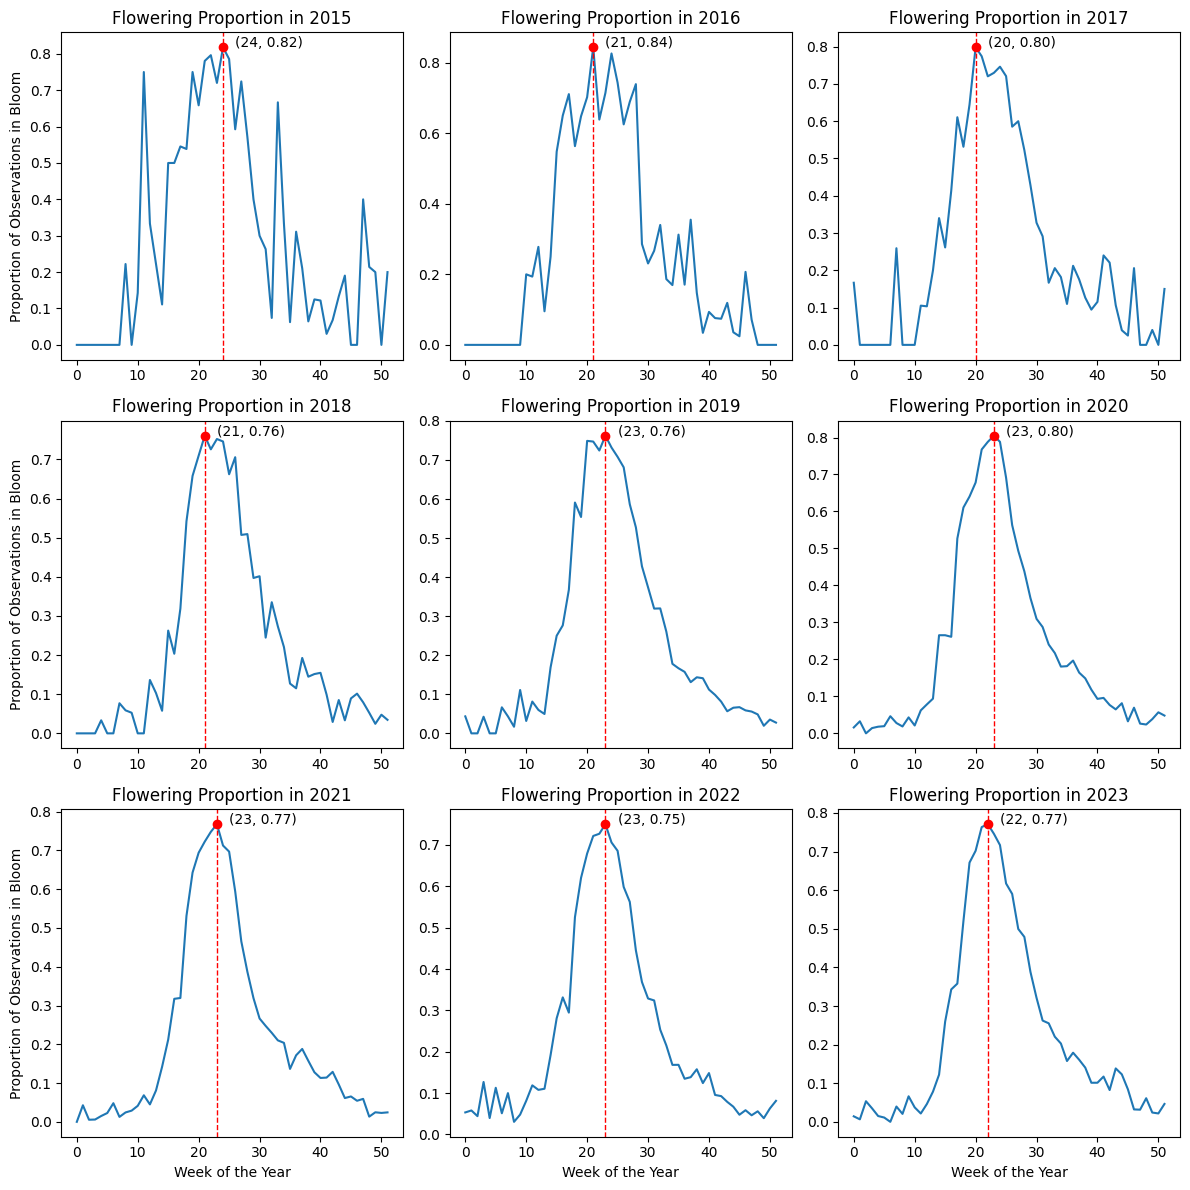

In [33]:
# Initialize the plot with smaller size
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Loop through each year and create a plot in the corresponding subplot
for i, year in enumerate(proportions.columns):
    ax = axs[i]
    data = list(proportions[year])
    ax.plot(list(range(52)), data)
    
    # Find the peak of the data
    peak_index = data.index(max(data))
    peak_value = max(data)
    
    # Draw dashed line
    ax.axvline(x=peak_index, color='r', linestyle='--', linewidth=1)
    ax.plot(peak_index, peak_value, 'ro')  # Mark the peak on the curve
    
    # Annotate the peak
    ax.annotate(f'\n({peak_index}, {peak_value:.2f})', xy=(peak_index, peak_value), xytext=(peak_index + 2, peak_value))

    # Set labels conditionally
    if i % 3 == 0:  # First column
        ax.set_ylabel("Proportion of Observations in Bloom")
    if i // 3 == 2:  # Last row
        ax.set_xlabel("Week of the Year")
    ax.set_title("Flowering Proportion in " + str(year))

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

We see that the distribution of observed flowering proportion doesn't seem to be shifting significantly. This could be due to a variety of factors, including shifts in the geographic distribution of observations, a relatively small observation window, or limited phenological response to warming temperatures in roses. 